In [12]:
#from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

plt.rcParams["figure.figsize"] = (5,5)

from pandas_datareader import wb

import seaborn as sns

from sklearn import preprocessing

import seaborn as sns

In [13]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [14]:
def spiParametersMle(x, dist=st.gamma):
    i = x == 0
    params = dist.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x, dist=st.gamma):
    i = x == 0

    params = dist.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q, dist=st.gamma):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)


In [15]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

def deseasonalize_NoStd(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = result
    return(data_deseasonal,averages)


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))


In [16]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

result = np.load("ET_data.npy")
result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


In [18]:
dists = [st.gumbel_r, st.invgauss, st.lognorm, st.gamma, st.genextreme, st.dweibull]

In [19]:
names = ["gumbel_r", "invgauss", "lognorm", "gamma", "genextreme", "dweibull" ]

In [ ]:
for i in range(len(dists)):    
    result_index = []
    for k in range(d3):
        onset = k
        end = k + (n*f - (rolling_n - 1))

        a = RFThree.iloc[onset:end,:].values
        b = RFThree.iloc[end + (rolling_n - 1),:].values
        n_a = a.shape[1]
        index = np.zeros(n_a)

        for i in range(n_a):
            x = a[:,i]
            params,q = spiParametersMle(x,st.pearson3)
            r = spiGeneratorParamMle([b[i]], params, q, dists[i])
            index[i] = r

        result_index.append(index)
    filename = "ET_{}.npy".format(names[i])
    np.save(filename,np.array(result_index))

In [20]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) }
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

result = np.load("ET_data.npy")
result = pd.DataFrame(result)

rolling_n = 12
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]


/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


In [21]:
RFThree

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
11,735.679998,857.050011,1306.989986,1314.580015,951.720005,786.839999,953.230016,1157.980019,1632.659989,1601.100021,...,318.120000,633.120001,697.020006,661.699997,475.789998,406.539998,379.820001,222.920000,721.979997,556.960008
12,735.639998,857.010011,1306.439986,1313.970015,951.460005,786.749999,953.220016,1157.720019,1631.799990,1600.240021,...,318.110000,630.890001,695.150006,660.239997,474.549999,405.429998,379.000001,222.900000,720.769997,555.940008
13,739.429998,858.390011,1318.779986,1328.360016,959.900005,791.879999,953.390016,1163.850019,1649.679989,1619.050020,...,318.110000,638.430000,700.240006,664.349997,477.969999,407.759998,379.350001,222.910000,723.949997,558.370008
14,743.539999,850.290011,1318.049987,1330.970016,963.340004,795.690000,937.510016,1152.690019,1648.529990,1620.910019,...,331.039999,724.709996,792.410006,758.449999,566.090002,486.139995,459.810000,257.530001,819.459995,652.560010
15,722.980002,852.240012,1384.819987,1396.330017,978.910004,784.940000,923.160018,1175.830022,1748.279990,1724.080021,...,361.739996,695.489995,753.220004,714.420000,520.050009,439.530002,412.920001,260.530001,773.109989,605.550008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,951.909995,848.759996,1072.479992,1105.980005,1002.959996,973.509998,839.219996,937.200001,1190.460011,1193.060000,...,492.479995,656.140003,717.990000,682.770015,511.909996,458.309993,451.449992,392.490002,731.839996,565.200007
836,951.909995,848.759996,1072.479992,1105.980005,1002.959996,973.509998,840.779993,937.190006,1190.450016,1193.020007,...,502.759996,644.800007,705.189997,670.130015,501.019996,456.449992,457.479992,401.080003,721.900001,556.040003
837,951.909995,848.759996,1072.479992,1105.980005,1002.959996,973.509998,840.449991,937.170010,1190.430012,1192.940005,...,473.569993,590.790004,649.659998,614.510013,436.569999,367.079997,353.910000,325.820001,683.659999,517.290003
838,951.909995,848.759996,1072.479992,1105.980005,1002.959996,973.509998,840.459990,937.190010,1190.450013,1192.990004,...,472.749994,589.050004,646.529998,612.140013,432.239999,363.759997,351.770000,324.560002,679.559999,513.670002


In [ ]:
for j in range(len(dists)):
    result_index = []
    n = RFThree.shape[1]
    index = np.zeros(n)

    for i in range(n):
        x = RFThree.iloc[:,i].values
        params,q = spiParametersMle(x, dists[j])
        index[i] = spiGeneratorParamMle(x, params, q, dists[j])

    result_index.append(index)
    filename = "ET_{}_whole.npy".format(names[j])
    np.save(filename,np.array(result_index))


In [27]:
for i in range(n):
    params,q = spiParametersMle(RFThree.iloc[:,i].values)
    r = spiGeneratorParamMle(RFThree.iloc[:,i].values, params, q)

303

In [30]:
params,q = spiParametersMle(RFThree.iloc[:,0].values)
r = spiGeneratorParamMle(RFThree.iloc[:,0].values, params, q)

In [36]:
np.std(r)

0.9999992321024448

In [3]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [4]:
d = Data('../../nc/GPCC_half.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [32]:
spi12 = np.load("../results/SPI12Index.npy")
lat = np.load("../lat.npy")
lon = np.load("../lon.npy")

In [33]:
spi = spi12[1:,:]

In [5]:
coordinates = list(zip(lat_list,lon_list))

In [6]:
dic = rg.search(coordinates)

Loading formatted geocoded file...


In [7]:
country = []
for i in range(len(dic)):
    country.append(dic[i].get('cc'))

In [8]:
ET_index = np.where(np.array(country)== "ET")[0]

In [9]:
ET_data = result[:-1,ET_index]

In [12]:
np.save("ET_data.npy",ET_data)

In [13]:
ET_data.shape

(840, 303)

In [237]:
len(ET_index)

303

In [37]:
spi_et = spi[:,ET_index]

In [48]:
result = []
for i in range(spi_et.shape[0]):
    result.append(np.count_nonzero(spi_et[i,:]))

(468, 303)

In [190]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [191]:
df_count = pd.DataFrame(count,
                  columns=["number"],
                  index=pd.date_range("19770101", periods=len(count), freq='MS'))

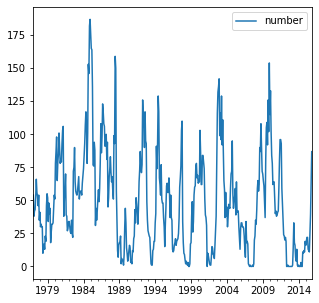

In [192]:
df_count.plot()

In [193]:
df_count.to_csv("ET_count_ex.csv")

In [211]:
ET_gamma = np.load("ET_pearson.npy")
N = ET_gamma.shape[0]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.ma.masked_invalid(ET_gamma[i,:]).mean())

In [274]:
df_extreme = pd.DataFrame({"count":count})
df_extreme = df_extreme.rolling(12).mean()
Idx = np.arange(11,N,12)
df_extreme = df_extreme.iloc[Idx,:]
year = np.arange(1977,2016)
df_extreme["year"] = year

In [275]:
dat = wb.download(indicator='SP.POP.TOTL', country=['ET'], start=1940, end=2019)
year = np.arange(2019,1959, -1)
df = pd.DataFrame({"year":year,"POP":dat["SP.POP.TOTL"].values})



et = pd.read_csv("Data_6.csv")
et  = et.iloc[:,[0,4]]
et = et.dropna()
et["year"] = pd.to_numeric(et["year"])
data = et.merge(df)
data["drought"] = data["Affected"]/data["POP"]
data_et = data.drop(['Affected', 'POP'], axis=1)

In [276]:
df_extreme = df_extreme.merge(data_et, how='left')
df_extreme = df_extreme.set_index("year")
df_extreme = df_extreme.fillna(0)
df_extreme = (df_extreme - df_extreme.mean())/df_extreme.std()

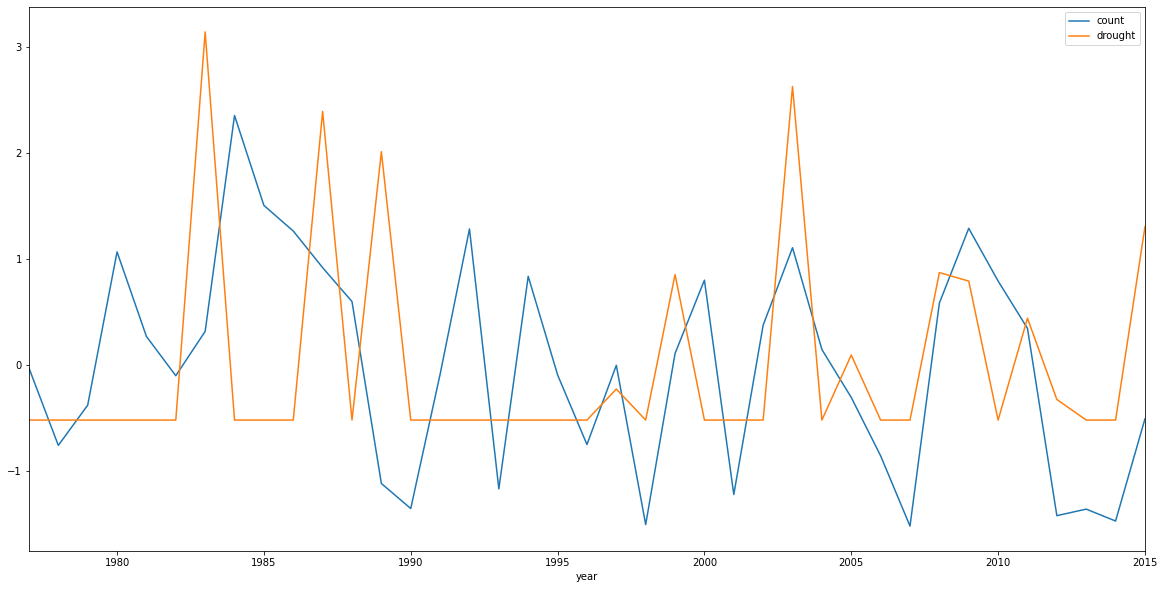

In [277]:
df_extreme.plot()

In [280]:
df_extreme.corr()

,count,drought
count,1.00000,0.16064
drought,0.16064,1.00000


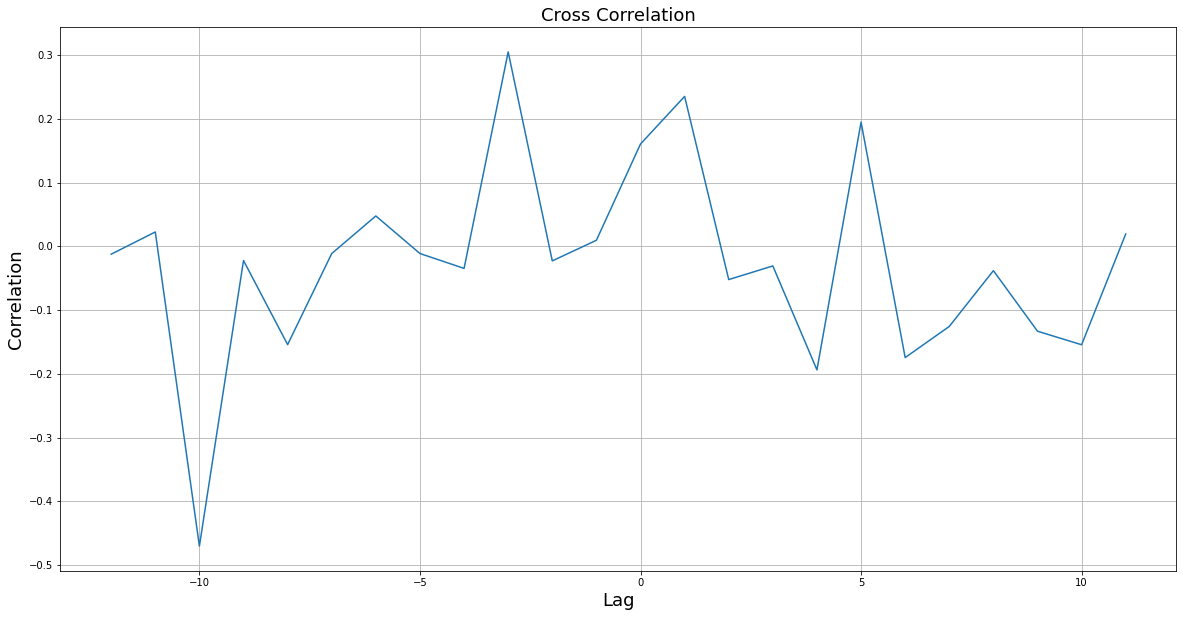

In [281]:
xcov_monthly = [ef.crosscorr(df_extreme["count"],df_extreme["drought"],lag=i) for i in range(-12,12)]
lag = np.arange(-12,12)

fig = plt.figure()
plt.plot(lag, xcov_monthly)
plt.title("Cross Correlation", fontsize = 18)
plt.ylabel("Correlation", fontsize = 18)
plt.xlabel("Lag", fontsize = 18)
plt.grid()
#filename = "../plots/IDD/Corr_{}.png".format(cluster)
#fig.savefig(filename)

In [39]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


In [40]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [56]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

In [57]:
df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

In [58]:
extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.matrix(df_cluster[0])
result_pres = np.matrix(df_cluster[1])
result_sat = np.matrix(df_cluster[2])
result_sst = np.matrix(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.matrix(result)

In [38]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

In [ ]:
data_pre = pd.DataFrame(result)

In [17]:
ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [18]:
n_components = 60
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [19]:
pre = Data('../../nc/world_precipitation.nc','precip',temporal_limits, missing_value= -9.96921e+36)

result_pre = pre.get_data()
lon_pre_list = pre.get_lon_list()
lat_pre_list = pre.get_lat_list()
lon_pre = pre.get_lon()
lat_pre = pre.get_lat()

result_pre = pf.deseasonalize(np.array(result_pre))
data_pre = pd.DataFrame(result_pre)

n_components_pre = 10

scale = StandardScaler()
scaled_data = scale.fit_transform(data_pre)

pca = PCA(n_components=n_components_pre)
pca_model = pca.fit(scaled_data)

df_cluster_pre = pca_model.transform(data_pre)


Matrix = pd.DataFrame(np.transpose(pca_model.components_))
Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_pre = pd.DataFrame(pf.varimax(Matrix.values, q=1000))

#Matrix = np.transpose(pca_model.components_)
#loading_pre = pd.DataFrame(pf.varimax(Matrix, q=1000))


clusters = loading_pre.idxmax(axis=1)
df_pre = pd.DataFrame({"lons":lon_pre_list,"lats":lat_pre_list,"clusters":clusters.values.tolist()})

lon_temp = df_pre["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pre["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


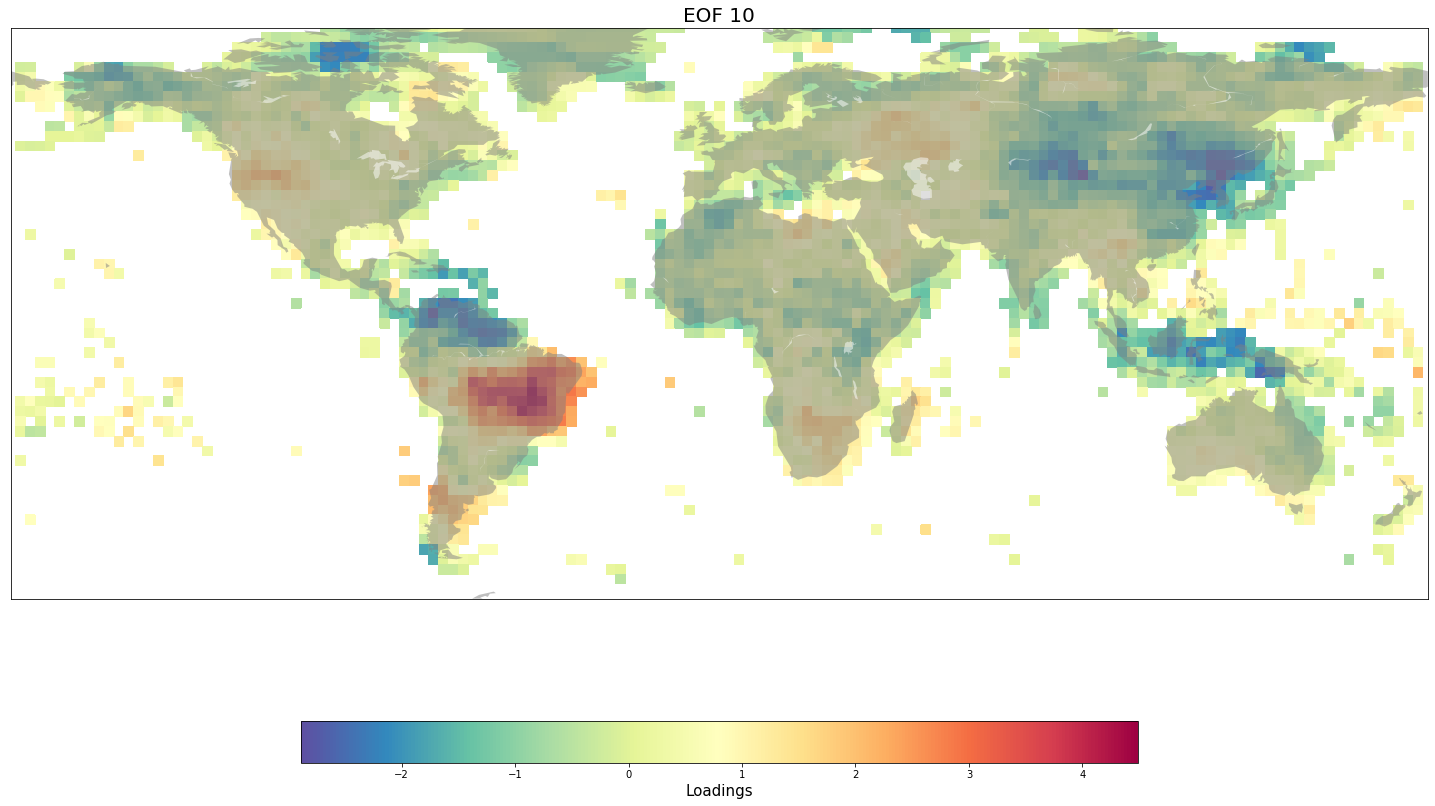

In [189]:
pc = 9
df_pre["pc"] = loading_pre[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_pre = np.arange(-178.75,180,2.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_pre),len(lon1_pre)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_pre[(df_pre.lats == lat_pre[i]) & (df_pre.lons == lon1_pre[j])].clusters.values.size == 0:
            deg[i,j] = df_pre[(df_pre.lats == lat_pre[i]) & (df_pre.lons == lon1_pre[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_pre, lat_pre)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc+1),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [20]:
sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))
data_sst = pd.DataFrame(result_sst)

n_components_sst = 20

scale = StandardScaler()
scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(scaled_data)

df_cluster_sst = pca_model.transform(data_sst)


Matrix = pd.DataFrame(np.transpose(pca_model.components_))
Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_sst = pd.DataFrame(pf.varimax(Matrix.values, q=1000))

#Matrix = np.transpose(pca_model.components_)
#loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))


clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


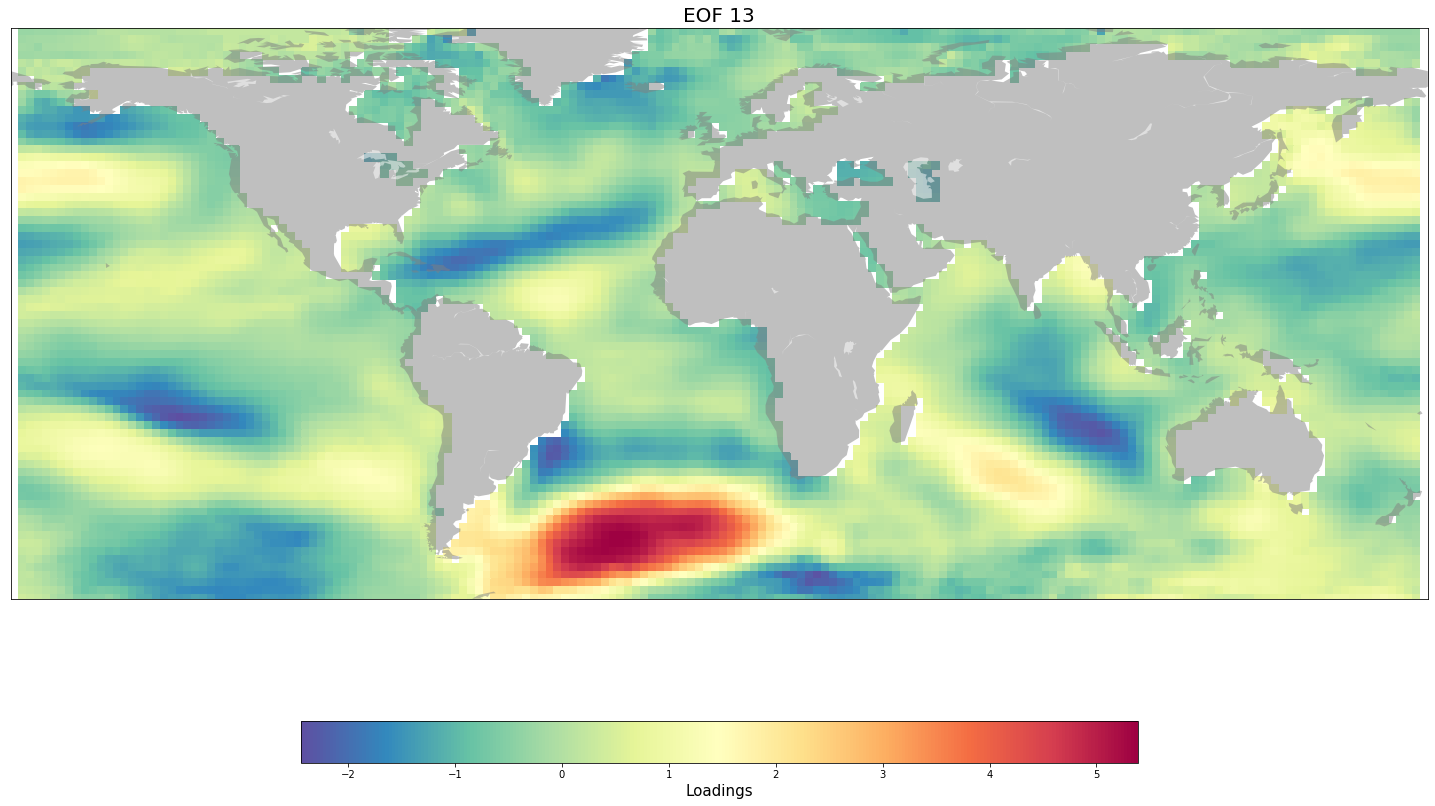

In [156]:
pc = 12
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc+1),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


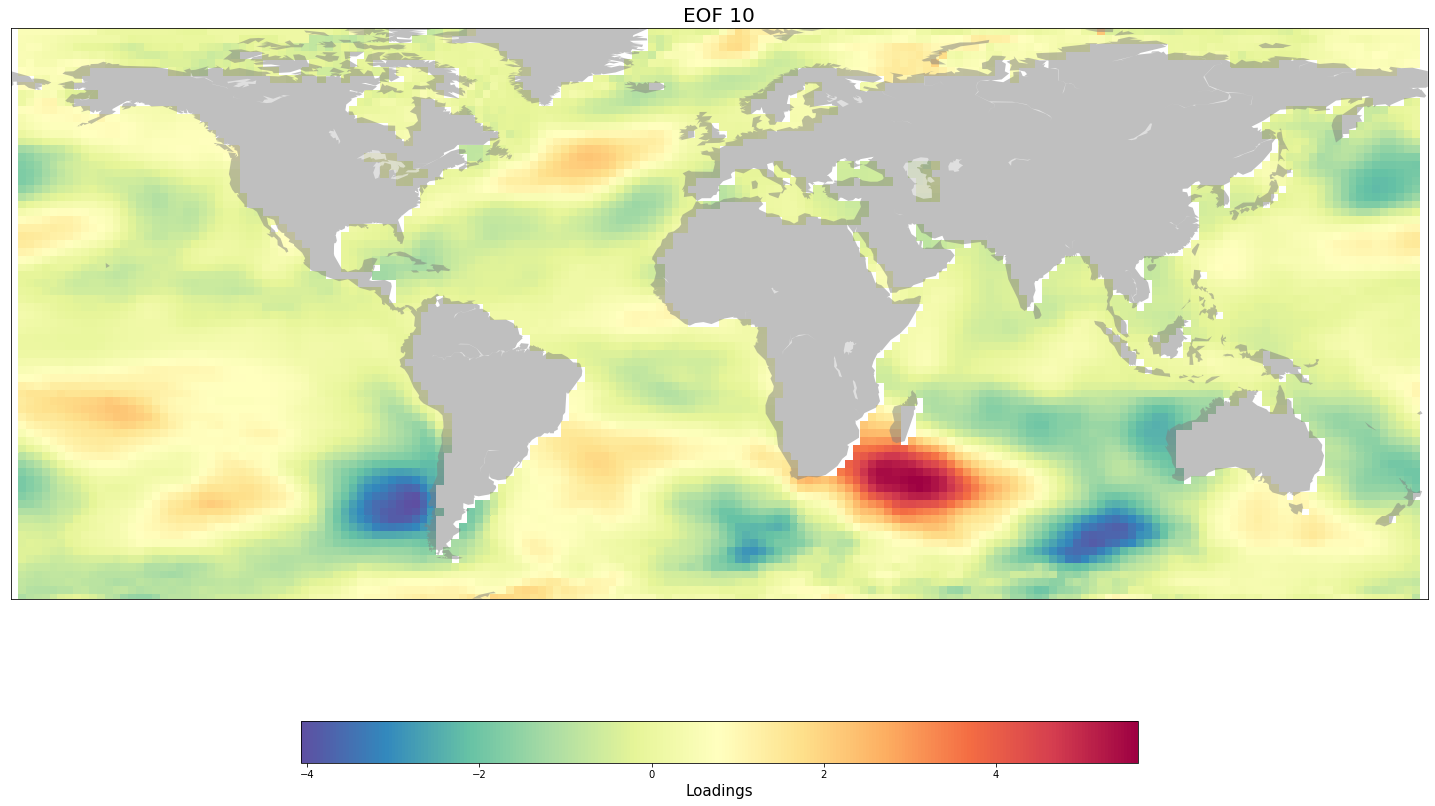

In [157]:
pc = 9
df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].clusters.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map =Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('Loadings', fontsize = 15)
plt.title("EOF %d"%(pc+1),fontsize = 20)
#plt.savefig("EOF%d.png"%(pc+1))
plt.show()

In [21]:
count_name  = ["count"]

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

pre_name  = []
for i in range(n_components_pre):
    pre_name.append("PRE_%d"%i)
#
var_names = count_name + pre_name
#

result_d = np.array(count)
result_d = result_d.reshape((len(count),1))
#result_sst = np.matrix(df_cluster_sst)
result_pre = np.array(df_cluster_pre)

result = np.concatenate((result_d,result_pre), axis=1)
result = np.array(result)

In [22]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [24]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
#save_obj(results, "results")
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable count has 7 link(s):
        (count -1): pval = 0.00000 | val = 0.673
        (PRE_5 -1): pval = 0.00000 | val = 0.257
        (PRE_1 -1): pval = 0.00000 | val = 0.220
        (PRE_4 -1): pval = 0.00755 | val = -0.126
        (PRE_9 0): pval = 0.00986 | val = 0.122
        (PRE_6 0): pval = 0.01563 | val = 0.114
        (PRE_1 -2): pval = 0.01743 | val = -0.112

    Variable PRE_0 has 6 link(s):
        (PRE_0 -1): pval = 0.00000 | val = 0.218
        (PRE_1 0): pval = 0.00012 | val = 0.181
        (PRE_4 -1): pval = 0.00820 | val = -0.125
        (PRE_6 -1): pval = 0.01113 | val = 0.119
        (PRE_3 -2): pval = 0.02105 | val = -0.109
        (PRE_0 -2): pval = 0.04321 | val = -0.096

    Variable PRE_1 has 8 link(s):
        (PRE_1 -1): pval = 0.00000 | val = 0.242
        (PRE_4 -2): pval = 0.00000 | val = 0.225
        (PRE_1 -2): pval = 0.00011 | val = 0.182
        (PRE_0 0): pval = 0.00012 | val = 0.181
        (PRE_0 -2): pv

In [73]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable count has 5 link(s):
        (count -1): pval = 0.00000 | qval = 0.00000 | val = 0.674
        (PRE_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.257
        (PRE_1 -1): pval = 0.00000 | qval = 0.00010 | val = 0.219
        (PRE_9 0): pval = 0.00256 | qval = 0.00256 | val = 0.141
        (PRE_6 0): pval = 0.01433 | qval = 0.01433 | val = 0.115

    Variable PRE_0 has 2 link(s):
        (PRE_0 -1): pval = 0.00000 | qval = 0.00009 | val = 0.221
        (PRE_1 0): pval = 0.00008 | qval = 0.00008 | val = 0.184

    Variable PRE_1 has 6 link(s):
        (PRE_1 -1): pval = 0.00000 | qval = 0.00002 | val = 0.241
        (PRE_4 -2): pval = 0.00000 | qval = 0.00007 | val = 0.226
        (PRE_0 0): pval = 0.00008 | qval = 0.00008 | val = 0.184
        (PRE_1 -2): pval = 0.00010 | qval = 0.00188 | val = 0.183
        (PRE_0 -2): pval = 0.00038 | qval = 0.00659 | val = -0.167
        (PRE_2 0): pval = 0.00092 | qval = 0.00092 | val = -0.155



In [134]:
n_components_sst = 15

sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()


result_sst = pf.deseasonalize(np.array(result_sst))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_sst)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

cluster_sst = []
for i in range(n_components_sst):
    Idx = np.where((df_sst.clusters == i).values)[0]
    r = result_sst[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    cluster_sst.append(pd.DataFrame(result_sst).mean(1))
    #scale = StandardScaler()
    #scaled_data = scale.fit_transform(data)
    #pca = PCA(n_components=n_components_sst)
    #pca_model = pca.fit(scaled_data)
    #pca_data = pca_model.transform(data)
    #cluster_sst.append(pca_data[:,0])

df_cluster_sst = pd.DataFrame(np.transpose(np.matrix(cluster_sst)))

scale = StandardScaler()
df_cluster_sst = scale.fit_transform(df_cluster_sst)

count_name  = ["count"]

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

#
var_names = count_name + sst_name

result_d = np.array(count)
result_d = result_d.reshape((len(count),1))
result_sst = np.matrix(df_cluster_sst)

result = np.concatenate((result_d, result_sst,), axis=1)
result = np.matrix(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [135]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)

/home/mathsys2/.local/lib/python3.6/site-packages/tigramite-4.0.0b0-py3.6-linux-x86_64.egg/tigramite/independence_tests.py:1112: RuntimeWarning: divide by zero encountered in double_scalars
  trafo_val = value * np.sqrt(deg_f/(1. - value*value))



## Significant links at alpha = 0.01:

    Variable count has 2 link(s):
        (count -1): pval = 0.00000 | val = 0.698
        (count -12): pval = 0.00000 | val = -0.270

    Variable SST_0 has 194 link(s):
        (SST_1 0): pval = 0.00000 | val = 1.000
        (SST_2 0): pval = 0.00000 | val = 1.000
        (SST_3 0): pval = 0.00000 | val = 1.000
        (SST_4 0): pval = 0.00000 | val = 1.000
        (SST_5 0): pval = 0.00000 | val = 1.000
        (SST_6 0): pval = 0.00000 | val = 1.000
        (SST_7 0): pval = 0.00000 | val = 1.000
        (SST_8 0): pval = 0.00000 | val = 1.000
        (SST_9 0): pval = 0.00000 | val = 1.000
        (SST_10 0): pval = 0.00000 | val = 1.000
        (SST_11 0): pval = 0.00000 | val = 1.000
        (SST_12 0): pval = 0.00000 | val = 1.000
        (SST_13 0): pval = 0.00000 | val = 1.000
        (SST_14 0): pval = 0.00000 | val = 1.000
        (SST_0 -1): pval = 0.00000 | val = 0.954
        (SST_1 -1): pval = 0.00000 | val = 0.954
        (SST_2

In [136]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable count has 2 link(s):
        (count -1): pval = 0.00000 | qval = 0.00000 | val = 0.698
        (count -12): pval = 0.00000 | qval = 0.00000 | val = -0.270

    Variable SST_0 has 194 link(s):
        (SST_1 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_2 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_3 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_4 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_5 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_6 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_7 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_8 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_9 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_10 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_11 0): pval = 0.00000 | qval = 0.00000 | val = 1.000
        (SST_12 0): pval = 0.00000 | q

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


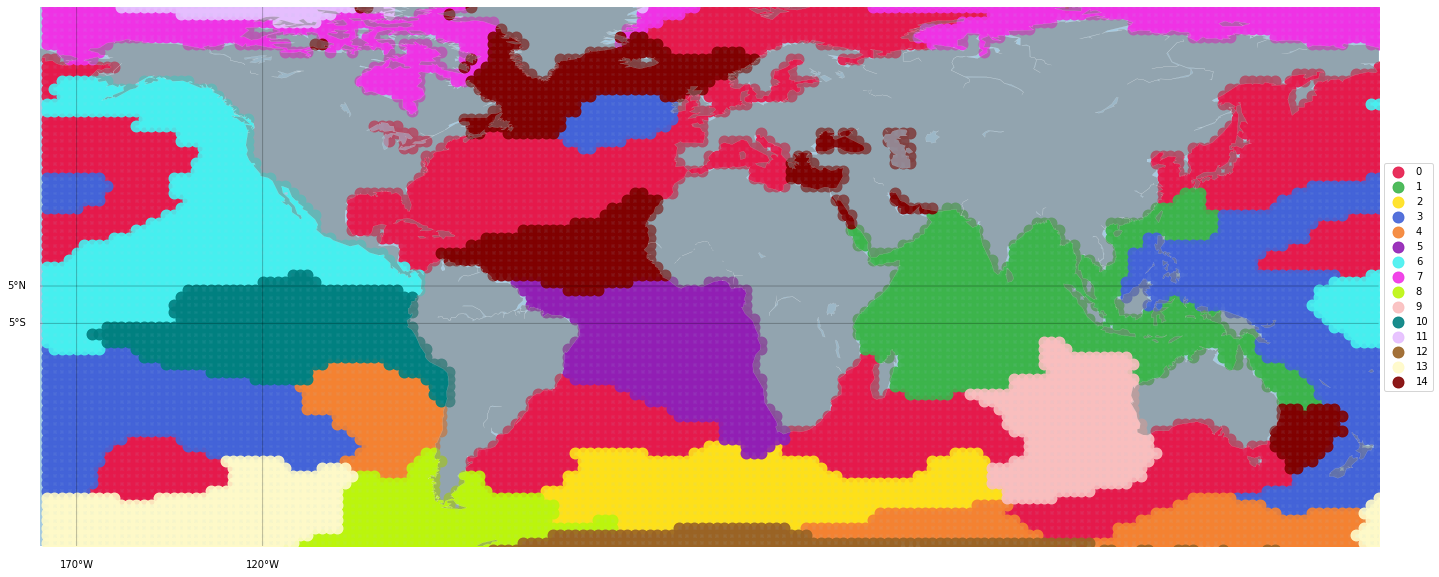

In [118]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawparallels(np.arange(int(-5),int(10),10),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-170),int(-80),50),labels=[0,0,0,1],linewidth=0.5)

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', 
#'#3690c0', '#0570b0', '#045a8d', '#023858', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = color_map(np.arange(0,n_components_sst,1),cm.RdYlBu)
#'#{:02x}{:02x}{:02x}{:02x}'.format( 120, 0 , 255, 128 )

#colors = pf.random_color(n_components_sst)

for i in range(n_components_sst):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=120, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


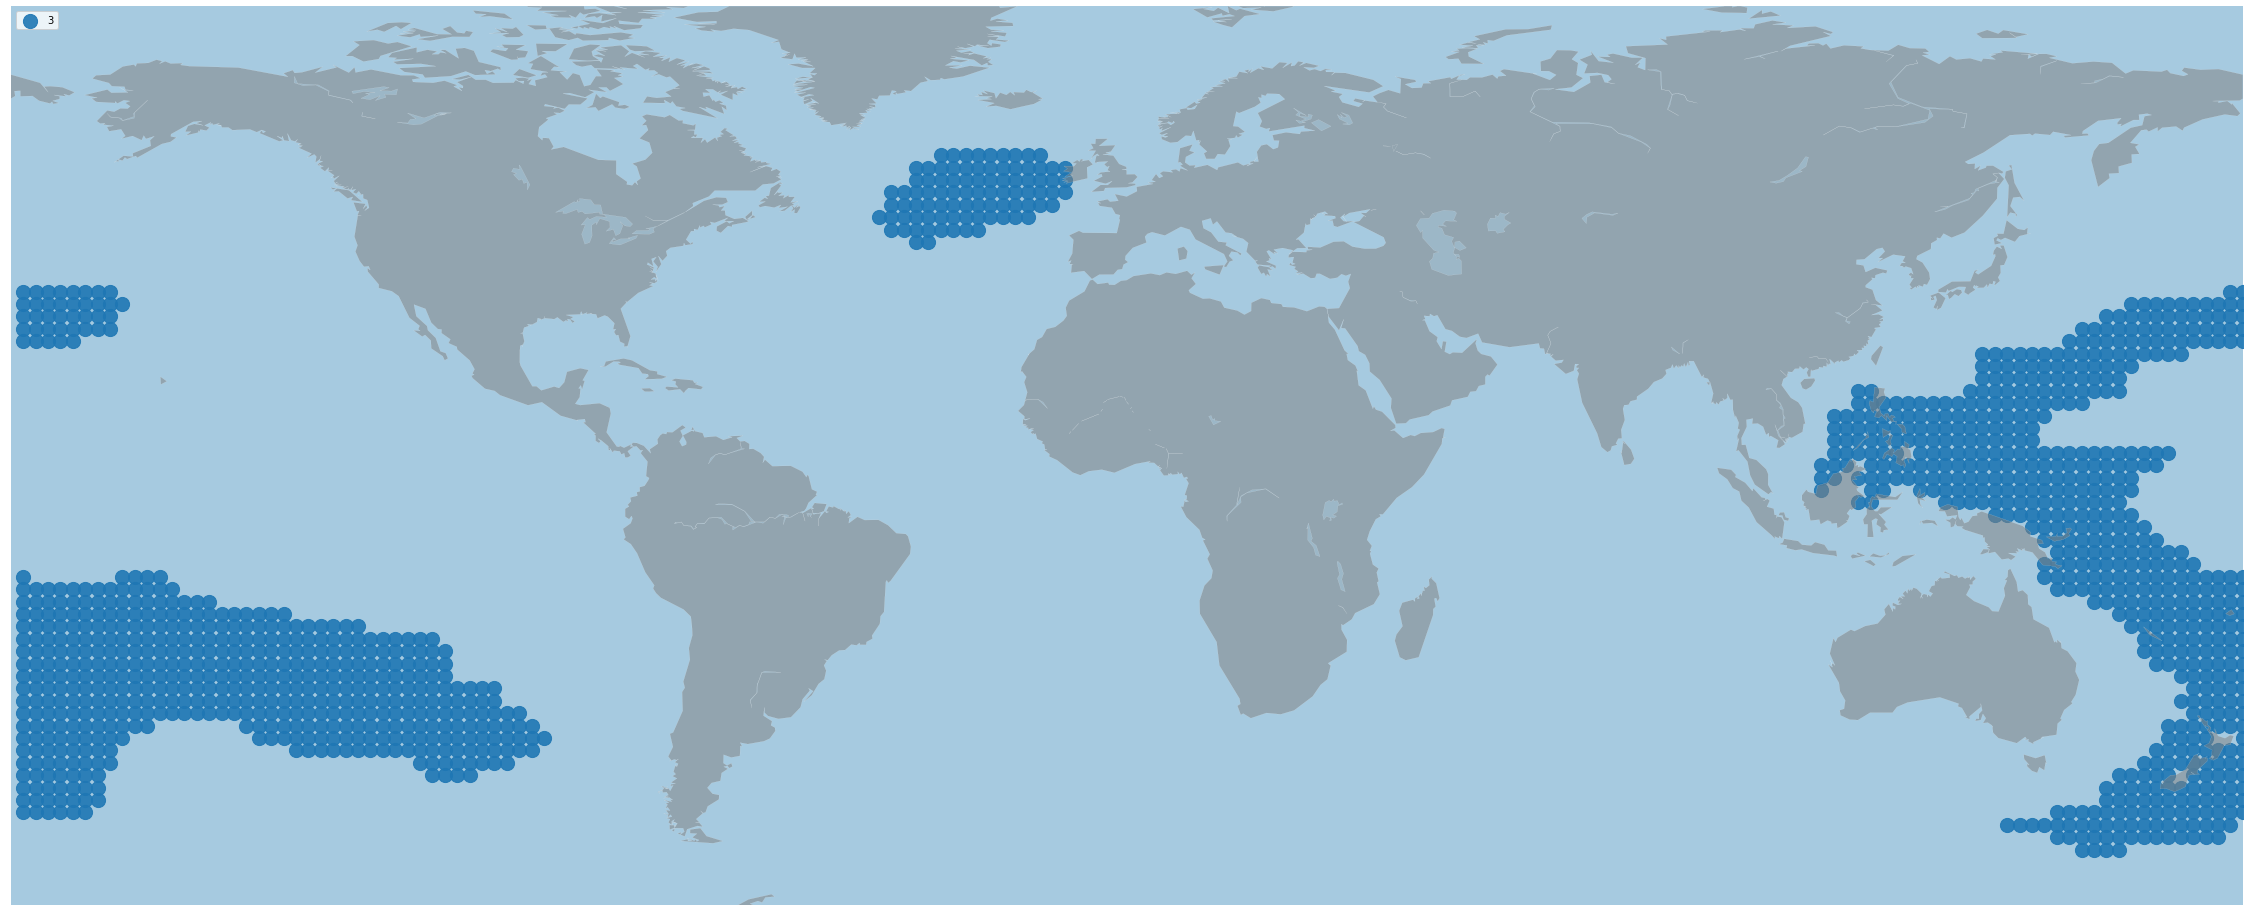

In [124]:
i = 3

df1 = df_sst[df_sst.clusters == i]

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")


lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()

In [42]:
x_scaled = min_max_scaler.fit_transform(Matrix)

In [43]:
df = pd.DataFrame(x_scaled)

In [44]:
df



,0,1,2,3,4,5,6,7,8,9
0,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
1,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
2,0.232174,0.507128,0.550462,0.598953,0.578592,0.519908,0.459239,0.458823,0.618160,0.589839
3,0.289321,0.562578,0.727303,0.222722,0.506587,0.513671,0.428408,0.490432,0.660328,0.507356
4,0.509109,0.558830,0.456644,0.615680,0.668573,0.583006,0.426213,0.531507,0.417861,0.569213
...,...,...,...,...,...,...,...,...,...,...
10983,0.331041,0.339664,0.149486,0.654869,0.583929,0.602713,0.407380,0.385180,0.548207,0.882346
10984,0.282679,0.347714,0.161898,0.691335,0.618418,0.571464,0.399623,0.378154,0.564496,0.853588
10985,0.232473,0.416850,0.193613,0.469087,0.596166,0.570314,0.432059,0.330204,0.675567,0.789316
10986,0.232293,0.466824,0.196958,0.496146,0.539074,0.548111,0.496509,0.318510,0.703613,0.683162


In [ ]:
stretched Gaussian